# Plot the streamlines on LLC4320

LLC4320 is a kilometer scale global simulation with complex grid topology. This is a good test for the performance of the package.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt 
import cmocean
import cartopy.crs as ccrs
from tqdm import tqdm
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib as mpl
import oceanspy as ospy

import seaduck as sd

mpl.rcParams['figure.dpi'] = 600

## Calculate the streamlines online
First we get the dataset into `OceData` object with help from `OceanSpy`. This step require the grid to be loaded into memory as numpy arrays and creating the cKD tree on top of that, so it is going to take some time. 

In [2]:
od = ospy.open_oceandataset.from_catalog('LLC4320')
ds = od._ds
oce = sd.OceData(ds)

Opening LLC4320.


10 day hourly data from the LLC4320 simulations computed using the MITGCM, a general, curvilinear ocean simulation on the cube-sphere.


Initiate the particles randomly so that they are distributed evenly on the globe.

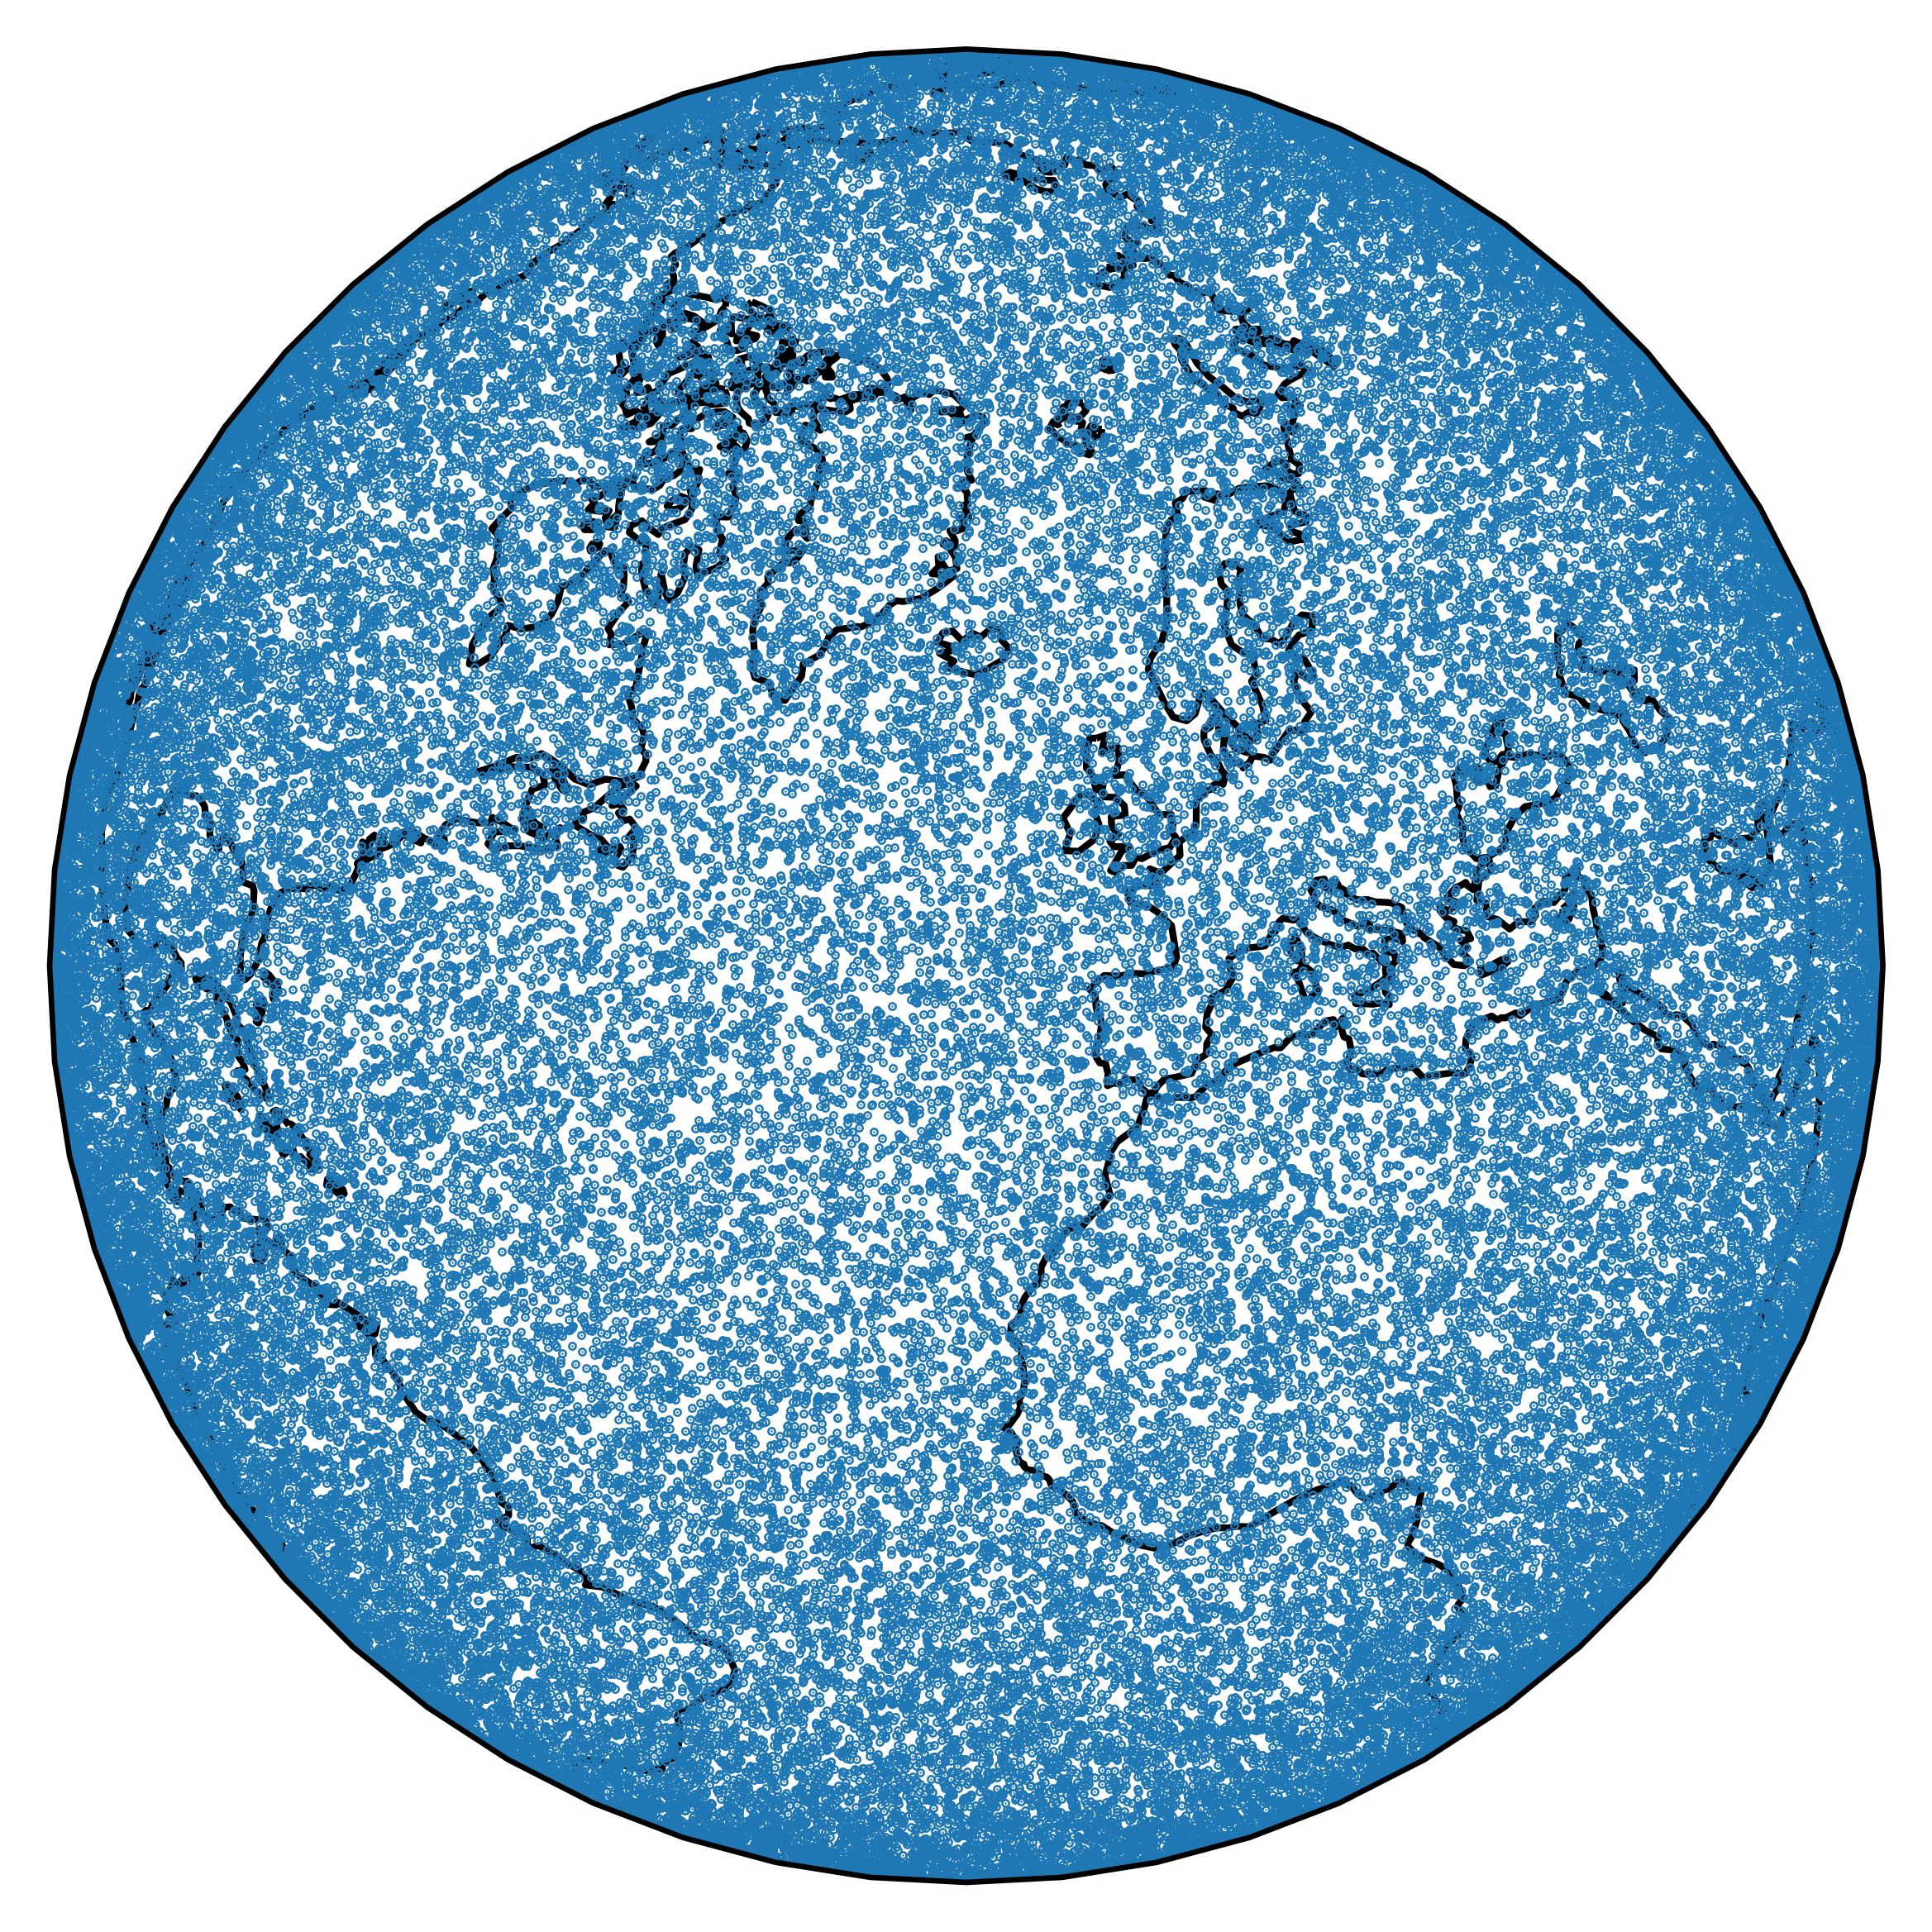

In [3]:
N = int(1.5e5)
np.random.seed(4320)
xx,yy,zz = [np.random.normal(size = N) for i in range(3)]
r = np.sqrt(xx**2+yy**2+zz**2)
y = (np.pi/2 - np.arccos(zz/r))*180/np.pi
x = np.arctan2(yy,xx)*180/np.pi
x = x[y>-80]
y = y[y>-80]
z = np.ones_like(x)*(-10.)
t = np.ones_like(x)*10.0

ax = plt.axes(projection = ccrs.Orthographic(central_longitude= -20.0, central_latitude= 45.0))
ax.plot(x,y,'o',markersize = 0.3, transform = ccrs.PlateCarree())
ax.coastlines()
# ax.set_xlim([-120,30])
# ax.set_ylim([10,70])
plt.show()

We will be using just one vertical layer of a single snapshot in the output to make the streamlines. 

In [4]:
oce['u'] = oce['U'][0,0]
oce['v'] = oce['V'][0,0]

By setting `wname = None`, we create a particle moving in the 2D mode. 

In [5]:
%%time
p = sd.Particle(x = x,y = y,z = z, t = t,data = oce,
                uname = 'u',vname = 'v',wname = None,
               )

CPU times: user 31.5 s, sys: 562 ms, total: 32.1 s
Wall time: 31.5 s


The package knows that LLC4320 is a large dataset, so it is not prefetching data to not overwhelm itself.

In general, this is a smart thing to do. However, since we are using the 2D velocity, which is much smaller than all the component, we actually have enough memory for prefetching. We can manually change that by:

In [6]:
p.too_large = False

In [7]:
p.uarray = np.array(oce['u'])
p.varray = np.array(oce['v'])

Everything went well. Now, we are going to run it with 3 hour timestep for 30 days. 

In [8]:
step = 10800
N = 240
dest = [n*step for n in range(1,N)]

In [ ]:
%%time
stops,raw = p.to_list_of_time(dest,update_stops = [])

We can now extract the things we need to plot, namely longitude, latitude, and horizontal speed. 

In [ ]:
lons = np.array([i.lon for i in raw])
lats = np.array([i.lat for i in raw])
spds = np.array([np.hypot(i.u*i.dx,i.v*i.dy) for i in raw])

If you would like to save the data for plotting, you can change the following raw block to code block and run it. 

If the location and speed is already pre-computed, they can be loaded by:

## Plotting Preparation

The ETOPO topography data set is also accessible on sciserver using `OceanSpy`. This will give us absolutely beautiful plots. 

In [ ]:
etopo = ospy.open_oceandataset.from_catalog('ETOPO')

For this notebook, we only need the over sea level part, because there is already so much going on in the water.

In [ ]:
etopo = etopo._ds.where(etopo._ds.Depth>0)

Here is the function for plotting. The lines will have use speed as colormaps. This part is going to take some time, but I hope you find it worth the wait. 

In [ ]:
def pretty_stream_plot(lats, lons, spds, projection, particle_bins = 1, bins = 5, north = 1000, south = -1000, plot_lines = True, save_as = None):
    fig = plt.figure(figsize = (16, 16))
    axs = plt.axes(projection = projection)
    axs.set_extent([-1e4, 1e4, south, north], crs=ccrs.PlateCarree())
    plt.tight_layout()
    axs.pcolormesh(etopo.X[::bins], 
                  etopo.Y[::bins], 
                  etopo.Depth[::bins,::bins], 
                  transform=ccrs.PlateCarree(), 
                  cmap='bone',vmin= -3000,vmax = 4500,
                  zorder = 20
              )
    axs.set_facecolor('lightsteelblue')
    print('finished making the map')
    if not plot_lines:
        print('skipping the lines')
        return
    # To speed up the computation, we transform the latlon outside the for plotting for-loop. 
    xx,yy,_ = projection.transform_points(ccrs.PlateCarree(),lons,lats).T

    xx = xx.T
    yy = yy.T

    for i in tqdm(range(0,lons.shape[1],particle_bins)):
        y = yy.T[i][1:]
        x = xx.T[i][1:]
        if np.max(x)-np.min(x)>300:
            x[x<0]+=360
        dydx = (0.5 * (spds.T[i][:-1] + spds.T[i][1:]))[1:]  # first derivative

        # Create a set of line segments so that we can color them individually
        # This creates the points as a N x 1 x 2 array so that we can stack points
        # together easily to get the segments. The segments array for line collection
        # needs to be (numlines) x (points per line) x 2 (for x and y)
        points = np.array([x, y]).T.reshape(-1, 1, 2)

        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a continuous norm to map from data points to colors
        norm = plt.Normalize(0, 1.)
        lc = LineCollection(segments, cmap='GnBu_r', norm=norm)
        # Set the values used for colormapping
        lc.set_array(dydx)
        lc.set_linewidth(0.3)
        line = axs.add_collection(lc)

    if save_as is not None:
        plt.savefig(save_as)

## Voila!
### Looking from Arctic

In [ ]:
north_projection = ccrs.NorthPolarStereo(central_longitude=38.0)
pretty_stream_plot(lats, lons, spds, north_projection, south = 6.5)
plt.show()

### Looking from Antarctica

In [ ]:
south_projection=ccrs.SouthPolarStereo(central_longitude=38.0)
pretty_stream_plot(lats, lons, spds, south_projection, north = -6.5)
plt.show()